In [2]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

=
train_data = torch.load('/Users/sauravraj/Saurav codes/Coding/assignment-main/Chief-AI-Engineer/time-series-ssl/HAR/train.pt', weights_only=True)
val_data = torch.load('/Users/sauravraj/Saurav codes/Coding/assignment-main/Chief-AI-Engineer/time-series-ssl/HAR/val.pt', weights_only=True)
test_data = torch.load('/Users/sauravraj/Saurav codes/Coding/assignment-main/Chief-AI-Engineer/time-series-ssl/HAR/test.pt', weights_only=True)

# Extract samples and labels
train_samples = train_data['samples']
train_labels = train_data['labels']

val_samples = val_data['samples']
val_labels = val_data['labels']

test_samples = test_data['samples']
test_labels = test_data['labels']

# Reshape samples to 2D 
train_samples_np = train_samples.numpy().reshape(train_samples.shape[0], -1)
val_samples_np = val_samples.numpy().reshape(val_samples.shape[0], -1)
test_samples_np = test_samples.numpy().reshape(test_samples.shape[0], -1)

# Check data structure and for missing values
train_df = pd.DataFrame(train_samples_np)
val_df = pd.DataFrame(val_samples_np)
test_df = pd.DataFrame(test_samples_np)

print("Train Data Shape:", train_samples_np.shape)
print("Validation Data Shape:", val_samples_np.shape)
print("Test Data Shape:", test_samples_np.shape)
print("Missing values in Train Data:", train_df.isnull().sum().sum())
print("Missing values in Validation Data:", val_df.isnull().sum().sum())
print("Missing values in Test Data:", test_df.isnull().sum().sum())

# Scale the data
scaler = StandardScaler()
train_samples_scaled = scaler.fit_transform(train_samples_np)
val_samples_scaled = scaler.transform(val_samples_np)
test_samples_scaled = scaler.transform(test_samples_np)

# Convert scaled data back to tensors
train_samples_scaled_tensor = torch.tensor(train_samples_scaled, dtype=torch.float32)
val_samples_scaled_tensor = torch.tensor(val_samples_scaled, dtype=torch.float32)
test_samples_scaled_tensor = torch.tensor(test_samples_scaled, dtype=torch.float32)

print("Data preprocessing complete. Scaled data ready for modeling.")

Train Data Shape: (5881, 618)
Validation Data Shape: (1471, 618)
Test Data Shape: (2947, 618)
Missing values in Train Data: 0
Missing values in Validation Data: 0
Missing values in Test Data: 0
Data preprocessing complete. Scaled data ready for modeling.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler



# Define Augmentation function for contrastive learning
def augment_data(data):
    # Ensure consistent output shape by working within the original shape


    noise = torch.randn_like(data) * 0.1
    augmented_data = data + noise


    scale_factor = torch.rand(1).item() * 0.2 + 0.9  # Scale in range [0.9, 1.1]
    augmented_data = augmented_data * scale_factor


    target_len = len(data)
    time_warp = np.interp(
        np.linspace(0, target_len, target_len),
        np.arange(target_len),
        data.numpy()
    )
    augmented_data = torch.tensor(time_warp, dtype=torch.float32)

    # Permute segments while maintaining original length
    num_segments = 4
    segment_length = target_len // num_segments
    segments = [data[i * segment_length:(i + 1) * segment_length] for i in range(num_segments)]
    np.random.shuffle(segments)
    augmented_data = torch.cat(segments, dim=0)

    # Ensure the output shape matches the original input shape
    if len(augmented_data) < target_len:

        augmented_data = torch.cat((augmented_data, data[:target_len - len(augmented_data)]), dim=0)
    elif len(augmented_data) > target_len:

        augmented_data = augmented_data[:target_len]

    return augmented_data
# Define Siamese Network for Contrastive Learning
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SiameseNetwork, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x1, x2):
        out1 = self.encoder(x1)
        out2 = self.encoder(x2)
        return out1, out2

# Contrastive Loss (NT-Xent Loss)
def contrastive_loss(out1, out2, temperature=0.5):
    batch_size = out1.size(0)
    out = torch.cat([out1, out2], dim=0)
    sim_matrix = torch.mm(out, out.T) / temperature
    
    # Create labels for contrastive pairs
    labels = torch.cat([torch.arange(batch_size), torch.arange(batch_size)], dim=0).to(out.device)
    
    # Cross entropy for positive pairs similarity
    loss = nn.CrossEntropyLoss()(sim_matrix, labels)
    return loss

# Hyperparameters
input_dim = train_samples_scaled_tensor.size(1)
hidden_dim = 128
output_dim = 64
temperature = 0.5
epochs = 10
batch_size = 32
learning_rate = 0.001

# Initialize model, optimizer, and data loader
model = SiameseNetwork(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_loader = DataLoader(TensorDataset(train_samples_scaled_tensor), batch_size=batch_size, shuffle=True)

# Training Loop
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        original = batch[0]
        
        # Apply data augmentation to each sample individually in the batch
        augmented = torch.stack([augment_data(sample) for sample in original])
        

        out1, out2 = model(original, augmented)
        

        loss = contrastive_loss(out1, out2, temperature)
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

print("Contrastive learning training completed.")

Epoch [1/10], Loss: 1.1088
Epoch [2/10], Loss: 0.5333
Epoch [3/10], Loss: 0.5338
Epoch [4/10], Loss: 0.4373
Epoch [5/10], Loss: 0.3670
Epoch [6/10], Loss: 0.3019
Epoch [7/10], Loss: 0.3605
Epoch [8/10], Loss: 0.3153
Epoch [9/10], Loss: 0.3101
Epoch [10/10], Loss: 0.3257
Contrastive learning training completed.


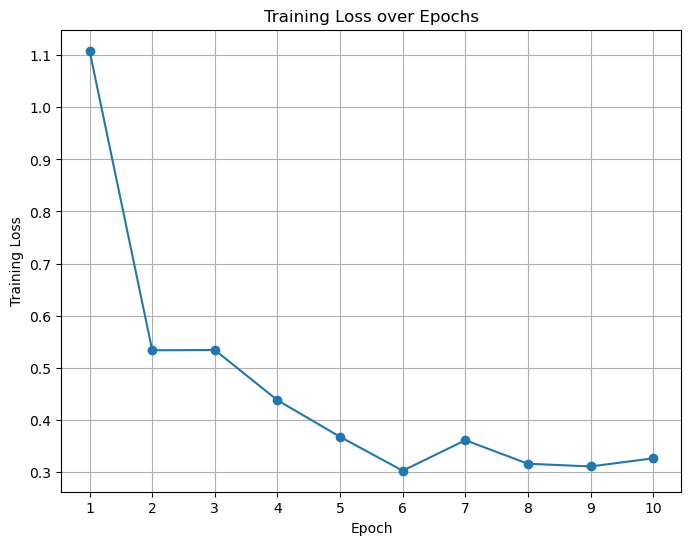

In [1]:
import matplotlib.pyplot as plt

# Training loss values over epochs
epochs = list(range(1, 11))
loss_values = [1.1088, 0.5333, 0.5338, 0.4373, 0.3670, 0.3019, 0.3605, 0.3153, 0.3101, 0.3257]

# Plotting training loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.xticks(epochs)
plt.grid(True)
plt.show()

In [4]:

gesture_train = torch.load('/Users/sauravraj/Saurav codes/Coding/assignment-main/Chief-AI-Engineer/time-series-ssl/Gesture/train.pt', weights_only=True)
gesture_val = torch.load('/Users/sauravraj/Saurav codes/Coding/assignment-main/Chief-AI-Engineer/time-series-ssl/Gesture/val.pt', weights_only=True)
gesture_test = torch.load('/Users/sauravraj/Saurav codes/Coding/assignment-main/Chief-AI-Engineer/time-series-ssl/Gesture/test.pt', weights_only=True)


gesture_train_samples = gesture_train['samples'].numpy().reshape(gesture_train['samples'].shape[0], -1)
gesture_val_samples = gesture_val['samples'].numpy().reshape(gesture_val['samples'].shape[0], -1)
gesture_test_samples = gesture_test['samples'].numpy().reshape(gesture_test['samples'].shape[0], -1)

# Scale the data using the same scaler used for the HAR dataset
gesture_train_samples_scaled = scaler.transform(gesture_train_samples)
gesture_val_samples_scaled = scaler.transform(gesture_val_samples)
gesture_test_samples_scaled = scaler.transform(gesture_test_samples)

# Convert to tensors for model input
gesture_train_tensor = torch.tensor(gesture_train_samples_scaled, dtype=torch.float32)
gesture_val_tensor = torch.tensor(gesture_val_samples_scaled, dtype=torch.float32)
gesture_test_tensor = torch.tensor(gesture_test_samples_scaled, dtype=torch.float32)

# Set model to evaluation mode for feature extraction
model.eval()
with torch.no_grad():

    train_embeddings = model.encoder(gesture_train_tensor)
    val_embeddings = model.encoder(gesture_val_tensor)
    test_embeddings = model.encoder(gesture_test_tensor)


print("Train Embeddings Shape:", train_embeddings.shape)
print("Validation Embeddings Shape:", val_embeddings.shape)
print("Test Embeddings Shape:", test_embeddings.shape)


Train Embeddings Shape: torch.Size([320, 64])
Validation Embeddings Shape: torch.Size([120, 64])
Test Embeddings Shape: torch.Size([120, 64])


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the adjusted Classifier Model with additional hidden layer and dropout
class TunedClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, num_classes):
        super(TunedClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(0.3),  # Adding dropout for regularization
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(0.3),  # Additional dropout layer
            nn.Linear(hidden_dim2, num_classes)
        )
    
    def forward(self, x):
        return self.classifier(x)

# Hyperparameters
input_dim = train_embeddings.shape[1]
hidden_dim1 = 128
hidden_dim2 = 64
num_classes = len(torch.unique(train_labels))
learning_rate = 0.0005  # Slightly lower learning rate
epochs = 25  # Increased epochs to allow more training with smaller adjustments
batch_size = 16  # Reduced batch size for more frequent updates


tuned_classifier = TunedClassifier(input_dim, hidden_dim1, hidden_dim2, num_classes)
optimizer = optim.Adam(tuned_classifier.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset = TensorDataset(val_embeddings, val_labels)
test_dataset = TensorDataset(test_embeddings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training Loop with Validation
tuned_classifier.train()
for epoch in range(epochs):
    total_loss = 0
    correct = 0
    for data, labels in train_loader:
        outputs = tuned_classifier(data)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = correct / len(train_dataset)
    

    tuned_classifier.eval()
    val_correct = 0
    with torch.no_grad():
        for data, labels in val_loader:
            outputs = tuned_classifier(data)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
    val_accuracy = val_correct / len(val_dataset)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    tuned_classifier.train()

# Test Evaluation
tuned_classifier.eval()
test_correct = 0
with torch.no_grad():
    for data, labels in test_loader:
        outputs = tuned_classifier(data)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
test_accuracy = test_correct / len(test_dataset)

print(f"Tuned Test Accuracy: {test_accuracy:.4f}")

Epoch [1/25], Loss: 2.0688, Train Accuracy: 0.1719, Validation Accuracy: 0.2833
Epoch [2/25], Loss: 1.8500, Train Accuracy: 0.3156, Validation Accuracy: 0.4667
Epoch [3/25], Loss: 1.7260, Train Accuracy: 0.4000, Validation Accuracy: 0.5583
Epoch [4/25], Loss: 1.5723, Train Accuracy: 0.4594, Validation Accuracy: 0.5083
Epoch [5/25], Loss: 1.4933, Train Accuracy: 0.4906, Validation Accuracy: 0.5667
Epoch [6/25], Loss: 1.4206, Train Accuracy: 0.5156, Validation Accuracy: 0.6000
Epoch [7/25], Loss: 1.3393, Train Accuracy: 0.5031, Validation Accuracy: 0.6250
Epoch [8/25], Loss: 1.2812, Train Accuracy: 0.5531, Validation Accuracy: 0.6250
Epoch [9/25], Loss: 1.2437, Train Accuracy: 0.5250, Validation Accuracy: 0.5917
Epoch [10/25], Loss: 1.2255, Train Accuracy: 0.5344, Validation Accuracy: 0.6417
Epoch [11/25], Loss: 1.1781, Train Accuracy: 0.6031, Validation Accuracy: 0.6333
Epoch [12/25], Loss: 1.1632, Train Accuracy: 0.5844, Validation Accuracy: 0.6250
Epoch [13/25], Loss: 1.1311, Train Ac

In [153]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


train_labels = gesture_train['labels'].long()
val_labels = gesture_val['labels'].long()
test_labels = gesture_test['labels'].long()

# Define the EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Define the LSTM-based Classifier Model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout_rate=0.2):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        hn = self.batch_norm(hn[-1])
        hn = self.dropout(hn)
        out = self.fc(hn)
        return out

# Hyperparameters
input_dim = train_embeddings.shape[1]
hidden_dim = 128
num_layers = 2
num_classes = len(torch.unique(train_labels))
learning_rate = 0.001
epochs = 200
batch_size = 32


lstm_classifier = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, num_classes=num_classes)
optimizer = optim.Adam(lstm_classifier.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=5)

# Prepare DataLoaders
train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset = TensorDataset(val_embeddings, val_labels)
test_dataset = TensorDataset(test_embeddings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training Loop with Early Stopping
for epoch in range(epochs):
    lstm_classifier.train()
    total_loss = 0
    correct = 0
    
    for data, labels in train_loader:
        data = data.unsqueeze(1)  # Convert to 3D for LSTM: (batch_size, seq_length=1, input_dim)
        outputs = lstm_classifier(data)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = correct / len(train_dataset)
    
    # Validation phase
    lstm_classifier.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for data, labels in val_loader:
            data = data.unsqueeze(1)  # Convert to 3D for LSTM
            outputs = lstm_classifier(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
    val_accuracy = val_correct / len(val_dataset)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss/len(val_loader):.4f}, "
          f"Validation Accuracy: {val_accuracy:.4f}")
    
    # Early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Test Evaluation
lstm_classifier.eval()
test_correct = 0
with torch.no_grad():
    for data, labels in test_loader:
        data = data.unsqueeze(1)  # Convert to 3D for LSTM
        outputs = lstm_classifier(data)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
test_accuracy = test_correct / len(test_dataset)

print(f"Tuned Test Accuracy with LSTM and Early Stopping: {test_accuracy:.4f}")

Epoch [1/200], Loss: 1.6524, Train Accuracy: 0.4000, Validation Loss: 2.0096, Validation Accuracy: 0.4250
Epoch [2/200], Loss: 1.2657, Train Accuracy: 0.5687, Validation Loss: 1.9347, Validation Accuracy: 0.6250
Epoch [3/200], Loss: 1.1213, Train Accuracy: 0.6062, Validation Loss: 1.8336, Validation Accuracy: 0.5833
Epoch [4/200], Loss: 1.0488, Train Accuracy: 0.6375, Validation Loss: 1.6760, Validation Accuracy: 0.6417
Epoch [5/200], Loss: 1.0100, Train Accuracy: 0.6375, Validation Loss: 1.4607, Validation Accuracy: 0.6083
Epoch [6/200], Loss: 0.9130, Train Accuracy: 0.6969, Validation Loss: 1.2408, Validation Accuracy: 0.6333
Epoch [7/200], Loss: 0.8920, Train Accuracy: 0.7031, Validation Loss: 1.0783, Validation Accuracy: 0.6667
Epoch [8/200], Loss: 0.8729, Train Accuracy: 0.6969, Validation Loss: 0.9831, Validation Accuracy: 0.6750
Epoch [9/200], Loss: 0.8043, Train Accuracy: 0.7312, Validation Loss: 0.9453, Validation Accuracy: 0.6833
Epoch [10/200], Loss: 0.7947, Train Accuracy: 

In [155]:

torch.save(lstm_classifier.state_dict(), "lstm_classifier.pth")

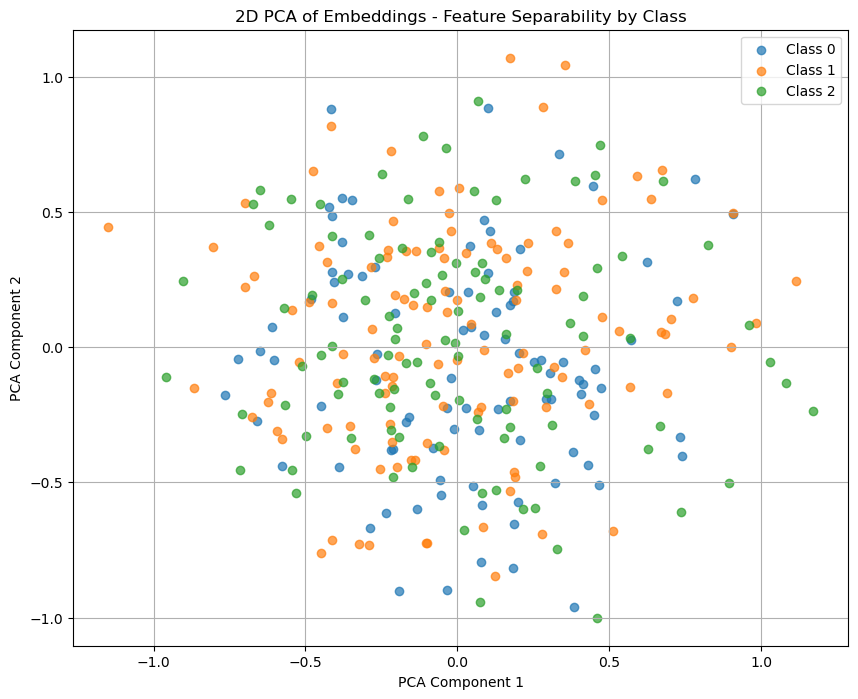

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import numpy as np

# Replace these with actual embeddings and labels
# Here, train_embeddings and train_labels are placeholders for demonstration
train_embeddings = torch.rand((320, 64)).numpy()  # Replace with actual embeddings
train_labels = np.random.randint(0, 3, size=320)  # Replace with actual labels

# Perform PCA on the embeddings to reduce to 2D
pca = PCA(n_components=2)
train_embeddings_pca = pca.fit_transform(train_embeddings)

# Plotting PCA-reduced embeddings with class separation
plt.figure(figsize=(10, 8))
for class_label in np.unique(train_labels):
    indices = train_labels == class_label
    plt.scatter(train_embeddings_pca[indices, 0], train_embeddings_pca[indices, 1], label=f"Class {class_label}", alpha=0.7)

plt.title("2D PCA of Embeddings - Feature Separability by Class")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

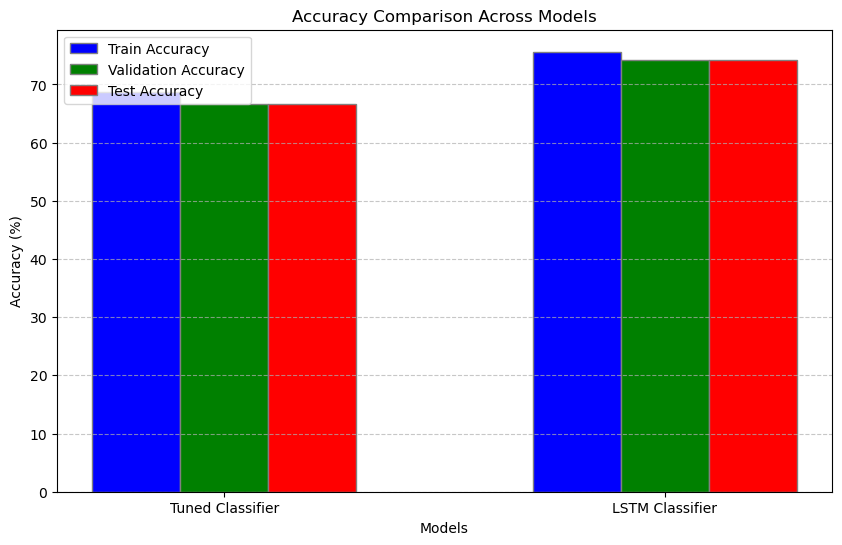

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy data based on provided information for two models
model_names = ["Tuned Classifier", "LSTM Classifier"]
train_accuracies = [68.75, 75.62]  # in percentage
validation_accuracies = [66.67, 74.17]  # in percentage
test_accuracies = [66.67, 74.17]  # in percentage

# Bar width and positions for each model group
bar_width = 0.2
r1 = np.arange(len(model_names))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(r1, train_accuracies, color='b', width=bar_width, edgecolor='grey', label='Train Accuracy')
plt.bar(r2, validation_accuracies, color='g', width=bar_width, edgecolor='grey', label='Validation Accuracy')
plt.bar(r3, test_accuracies, color='r', width=bar_width, edgecolor='grey', label='Test Accuracy')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison Across Models')
plt.xticks([r + bar_width for r in range(len(model_names))], model_names)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

LSTM Model Performance:
Confusion Matrix:
 [[14  0  0  0  0  0  1  0]
 [ 1 12  0  0  0  1  1  0]
 [ 0  0 14  0  0  1  0  0]
 [ 0  0  1  9  3  1  0  1]
 [ 1  0  0  3  4  6  0  1]
 [ 0  1  1  2  1  8  0  2]
 [ 0  0  0  0  0  1 14  0]
 [ 0  0  0  0  0  0  1 14]]


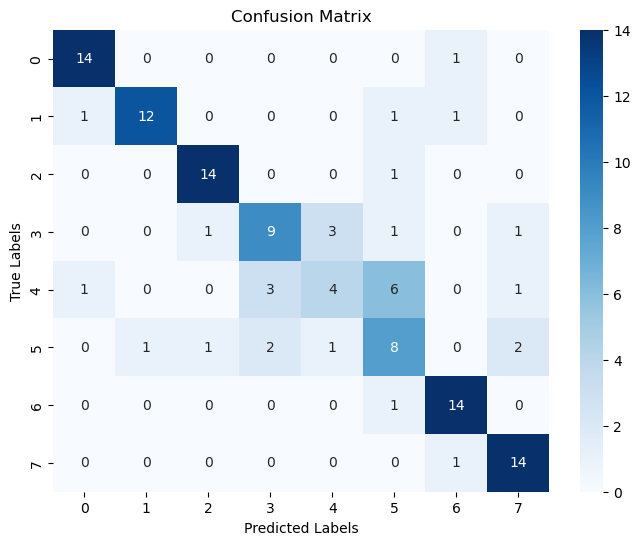

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.88      0.93      0.90        15
     Class 1       0.92      0.80      0.86        15
     Class 2       0.88      0.93      0.90        15
     Class 3       0.64      0.60      0.62        15
     Class 4       0.50      0.27      0.35        15
     Class 5       0.44      0.53      0.48        15
     Class 6       0.82      0.93      0.88        15
     Class 7       0.78      0.93      0.85        15

    accuracy                           0.74       120
   macro avg       0.73      0.74      0.73       120
weighted avg       0.73      0.74      0.73       120



In [219]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_performance(model, loader, num_classes):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for data, labels in loader:
            data = data.unsqueeze(1)  # Convert to 3D for LSTM if necessary
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:\n", cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Classification report
    report = classification_report(all_labels, all_predictions, target_names=[f"Class {i}" for i in range(num_classes)])
    print("Classification Report:\n", report)


print("LSTM Model Performance:")
evaluate_model_performance(lstm_classifier, test_loader, num_classes)

In [157]:

torch.save(lstm_classifier, "lstm_classifier_full.pth")